In [ ]:
import matplotlib as mpl
import scanpy as sc
import seaborn as sns

In [ ]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # 移除边框
)

# 预分析

 - 1. 加载数据
 - 2. 标准质控

 ## 1. 加载数据

In [ ]:
### 1.1 导入 h5ad 文件
adata = sc.read("./adata_raw.h5ad")
adata.X = adata.X.astype("float")

adata.X

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


<70926x17066 sparse matrix of type '<class 'numpy.float64'>'
	with 66953865 stored elements in Compressed Sparse Column format>

In [ ]:
### 1.2 修复来自 R 的基因名错误
fix_names = adata.var_names.str.replace(r'\.', '-', regex=True)
# 更新 adata 对象中的基因名
adata.var_names = fix_names

normalizing counts per cell
    finished (0:00:00)


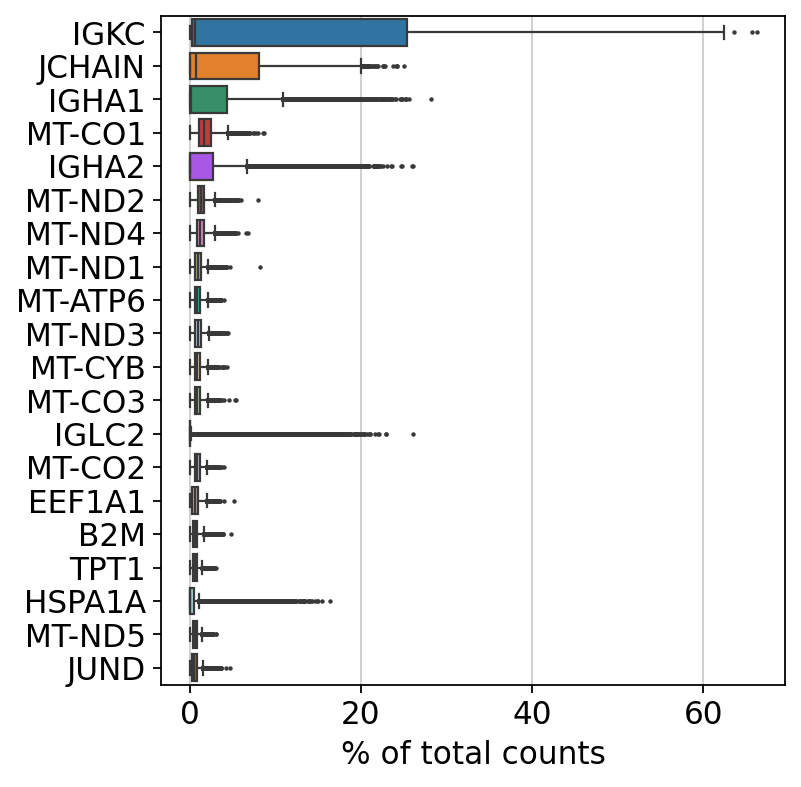

In [ ]:
### 1.3 查看基因在所有细胞中的表达情况
"""
    - 预期出现的基因类型，如线粒体基因、肌动蛋白、核糖体蛋白和 MALAT1 等。
    - 如果所有的外部对照转录本（spike-in transcripts）都在前 50 名中，可能意味着添加了过多的外部对照 RNA。
    - 大量的伪基因或预测的基因可能暗示着在基因比对过程中存在问题。
"""
sc.pl.highest_expr_genes(adata, n_top=20)

## 2. 标准质控

 - 2.1 识别线粒体基因、核糖体基因、血红蛋白基因
 - 2.2 计算 QC 指标
 - 2.3 绘制 QC 指标
 - 2.4 定义离群值函数
 - 2.5 检查一般参数的离群值（MAD=5）
 - 2.6 检查线粒体基因的离群值（MAD=3）
 - 2.7 过滤低质量细胞
 - 2.8 QC 可视化
 - 2.9 保存结果

In [ ]:
### 2.1 识别线粒体基因、核糖体基因、血红蛋白基因
# 线粒体基因
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")  # 忽略大小写
# 核糖体基因
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))
# 血红蛋白基因
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]", case=False)

In [ ]:
### 2.2 统计基因数量
print( f"""
线粒体基因数量总和: {adata.var["mt"].sum()}

核糖体基因数量总和: {adata.var["ribo"].sum()}

血红蛋白基因数量总和: {adata.var["hb"].sum()}
""")


线粒体基因数量总和: 13

核糖体基因数量总和: 98

血红蛋白基因数量总和: 6



In [ ]:
### 2.3 计算 QC 指标
"""
三种 QC 协变量：
    - total_counts：库大小，过大的库可能是两个细胞的混合物
    - pct_counts_mt：线粒体计数百分比
    - n_genes_by_counts：细胞中至少有 1 个计数的基因数量
----------------------------------
如果一个细胞正在死亡，那么其 mRNA 被释放到内环境，导致线粒体基因的比例较高。
但是，线粒体计数相对较高的细胞可能参与呼吸过程，不应被过滤掉。
计数低或高的细胞可能对应于静止细胞群或尺寸较大的细胞。
因此，我们在过滤低质量细胞时要同时考虑不同的 QC 协变量之间的关系。
----------------------------------
注意：calculate_qc_metrics() 中设置 inplace=True，质控绘图可能会受到数据标准化的影响。
"""
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo", "hb"],
    inplace=True,  # True，则将指标直接存储在 adata.obs 中
    percent_top=(20, 50, 100, 200, 500),  # 默认值
    log1p=True,
)
adata

AnnData object with n_obs × n_vars = 70926 × 17066
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

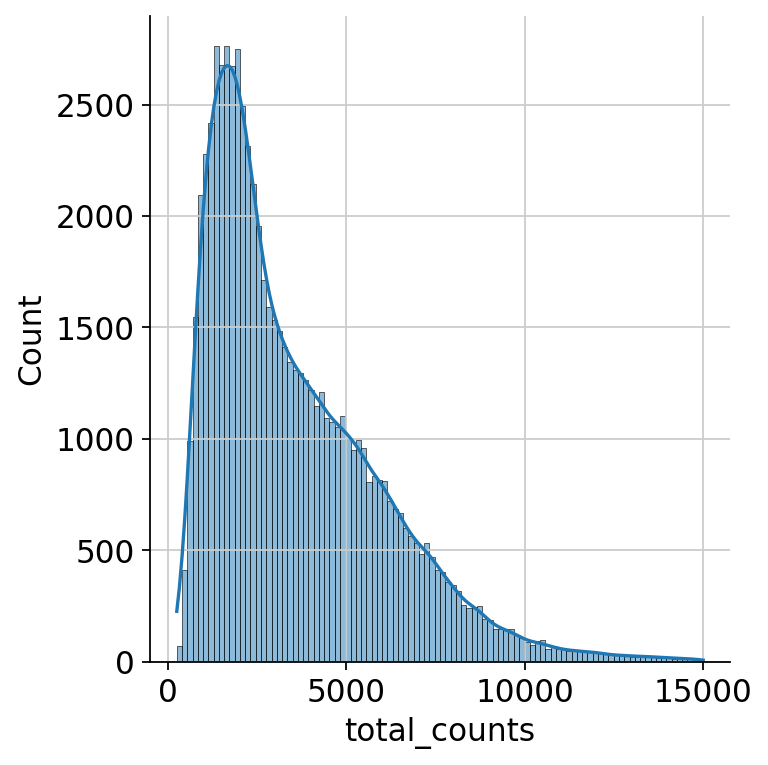

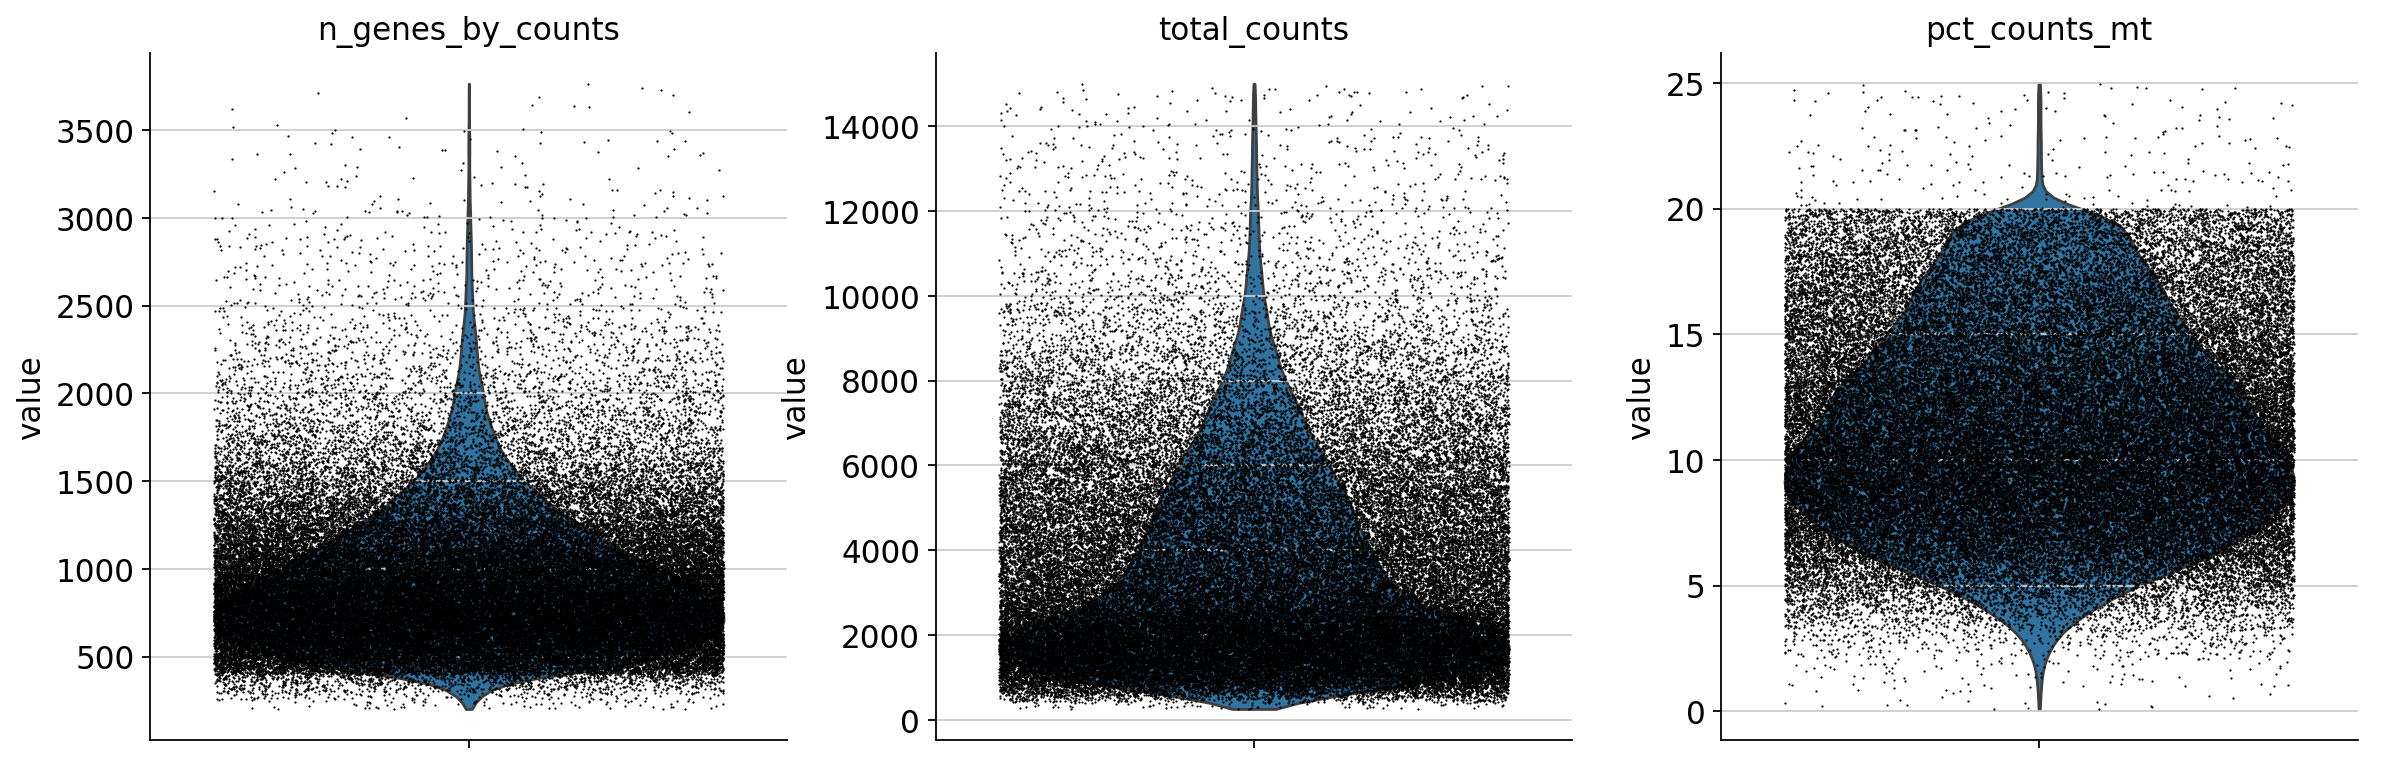

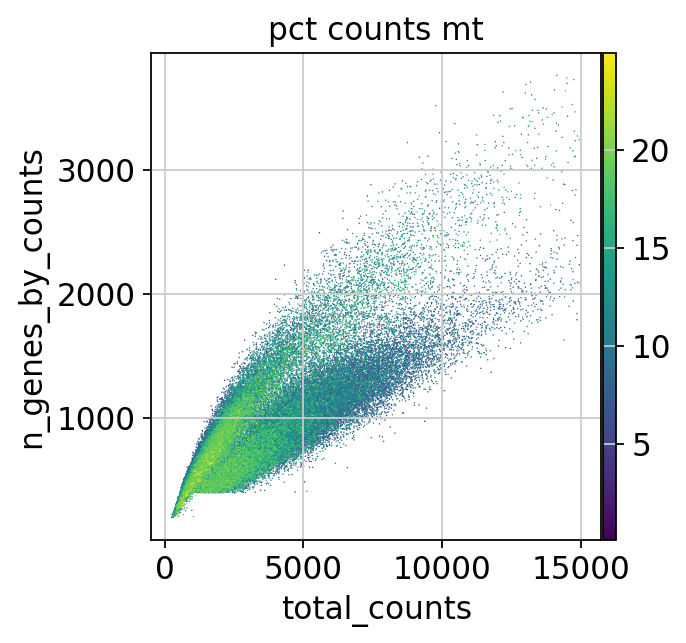

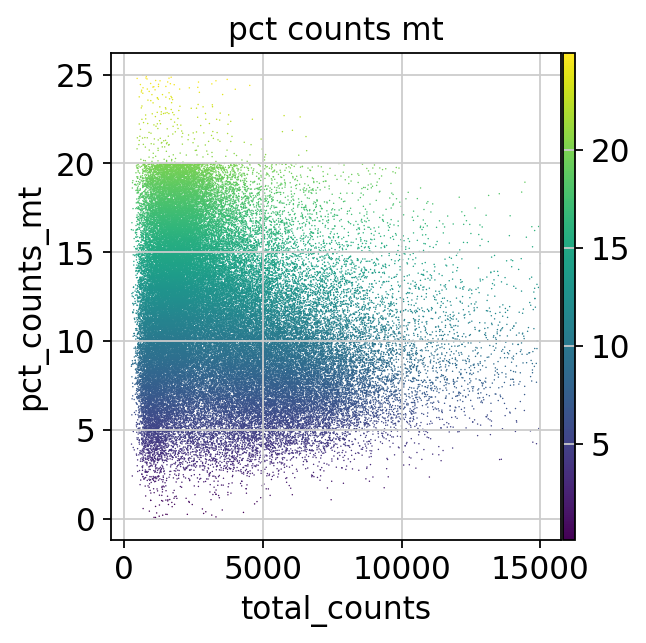

In [ ]:
### 2.4 绘制 QC 指标
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=True)
p2 = sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sc.pl.scatter(adata, "total_counts", "pct_counts_mt", color="pct_counts_mt")

In [ ]:
### 2.5 定义离群值函数
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
from typing import Optional, Tuple, Literal
from anndata import AnnData

def calculate_outlier_bounds(
    data: np.ndarray,
    nmads: float = 5,
    method: Literal['both', 'upper', 'lower'] = 'both',
    scale_mad: bool = False
) -> Tuple[float, float]:
    """
    使用中位数绝对偏差（MAD）计算异常值检测的上下界。

    参数:
        data (np.ndarray): 输入数据数组。
        nmads (float): MAD 的倍数，用于定义异常值界限。
        method (str): 'both' 表示双边检测，'upper' 仅检测上界，'lower' 仅检测下界。
        scale_mad (bool): 如果为 True，则 MAD 将乘以 1.4826，以适应正态分布标准差。

    返回:
        Tuple[float, float]: 下界和上界。
    """
    median = np.median(data)
    scale = 1.4826 if scale_mad else 1.0
    mad = median_abs_deviation(data, scale=scale)

    if method == 'upper':
        lower_bound = -np.inf
    else:
        lower_bound = median - nmads * mad

    if method == 'lower':
        upper_bound = np.inf
    else:
        upper_bound = median + nmads * mad

    return lower_bound, upper_bound

def validate_inputs(
    adata: AnnData,
    metric: str,
    nmads: float,
    batch_key: Optional[str]
) -> None:
    """验证输入参数，确保必要的字段存在于 adata.obs 中。"""
    if nmads <= 0:
        raise ValueError("参数 'nmads' 必须为正数。")
    if metric not in adata.obs:
        raise KeyError(f"指标 '{metric}' 未在 adata.obs 中找到。")

    if batch_key is not None and batch_key not in adata.obs:
        raise KeyError(f"批次键 '{batch_key}' 未在 adata.obs 中找到。")

def is_outlier(
    adata: AnnData,
    metric: str,
    nmads: float = 5,
    batch_key: Optional[str] = None,
    method: Literal['both', 'upper', 'lower'] = 'both',
    scale_mad: bool = False
) -> pd.Series:
    """
    使用 MAD 方法检测数据中的异常值，支持按批次处理。

    参数:
        adata (AnnData): 注释数据对象。
        metric (str): adata.obs 中用于异常值检测的指标名称。
        nmads (float): 定义异常值的 MAD 倍数。
        batch_key (str, optional): adata.obs 中用于定义批次的键。如果为 None，则将所有数据视为一个批次。
        method (str): 'both' 表示双边检测，'upper' 仅检测上异常值，'lower' 仅检测下异常值。
        scale_mad (bool): 如果为 True，则 MAD 将乘以 1.4826，以适应正态分布标准差。

    返回:
        pd.Series: 布尔序列，指示每个观测值是否为异常值。
    """
    validate_inputs(adata, metric, nmads, batch_key)

    data = adata.obs[metric]
    outlier_flags = pd.Series(False, index=data.index)

    if batch_key is None:
        # 单批次处理
        lower_bound, upper_bound = calculate_outlier_bounds(data.values, nmads, method, scale_mad)
        outlier_flags = (data < lower_bound) | (data > upper_bound)
    else:
        # 多批次处理
        grouped = data.groupby(adata.obs[batch_key])
        for batch, group_data in grouped:
            lower_bound, upper_bound = calculate_outlier_bounds(group_data.values, nmads, method, scale_mad)
            outliers_in_batch = (group_data < lower_bound) | (group_data > upper_bound)
            outlier_flags.loc[group_data.index] = outliers_in_batch

    return outlier_flags

In [ ]:
### 2.6 查看批次信息
adata.obs.batch.unique()

['s0920', 's1125', 's1231', 's0107', 's0115', 's0813']
Categories (6, object): ['s0107', 's0115', 's0813', 's0920', 's1125', 's1231']

In [ ]:
### 2.7 基础过滤
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 17066
filtered out 1 genes that are detected in less than 3 cells
Number of genes after cell filter: 17065


In [ ]:
### 2.8 检查一般参数的离群值（MAD=5）
MAD = 5

adata.obs["outlier"] = (
    is_outlier(adata, "total_counts", MAD, batch_key="batch")
    | is_outlier(adata, "n_genes_by_counts", MAD, batch_key="batch")
    | is_outlier(adata, "pct_counts_in_top_20_genes", MAD, batch_key="batch")
)

adata.obs.outlier.value_counts()

False    66003
True      4923
Name: outlier, dtype: int64

In [ ]:
### 2.9 检查线粒体基因的离群值（MAD=3）
adata.obs["mt_outlier"] = is_outlier(
    adata, "pct_counts_mt", 
    3, batch_key="batch",
    method="upper"
) | (
    adata.obs["pct_counts_mt"] > 20
)

adata.obs.mt_outlier.value_counts()

False    69402
True      1524
Name: mt_outlier, dtype: int64

In [ ]:
### 2.10 过滤低质量细胞
print(f"Total number of cells: {adata.n_obs}")
adata.obs["discard"] = adata.obs.outlier | adata.obs.mt_outlier
# 备份未过滤的数据
unfiltered = adata.copy()
# 过滤数据
adata = adata[~adata.obs.discard].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 70926
Number of cells after filtering of low quality cells: 64525


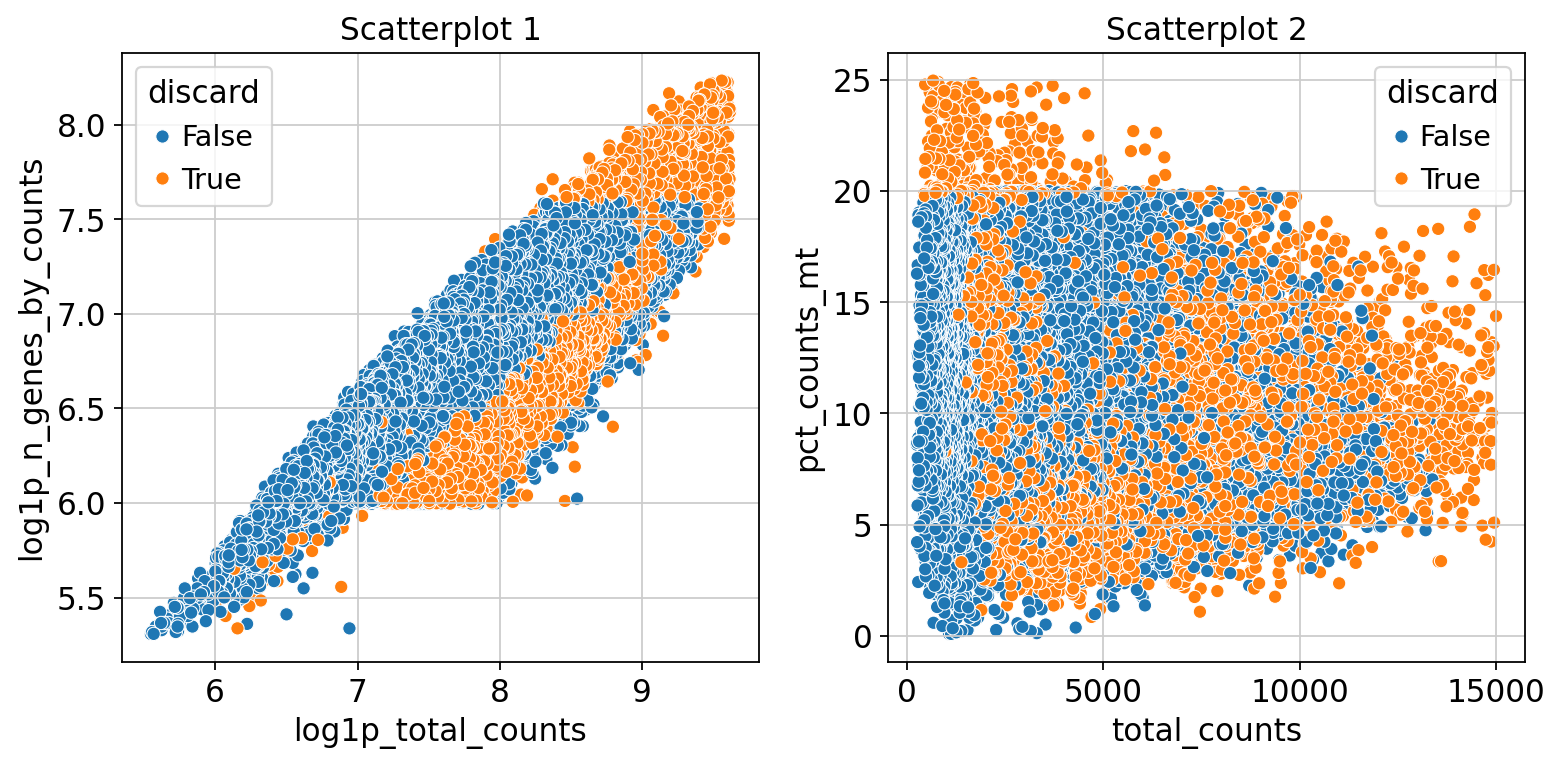

In [ ]:
### 2.11 QC 可视化
import matplotlib.pyplot as plt
import os

os.path.exists("figures") or os.mkdir("figures")
os.path.exists("table") or os.mkdir("table")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    hue="discard",
    data=unfiltered.obs,
    ax=axes[0],
)
axes[0].set_title("Scatterplot 1")

sns.scatterplot(
    x="total_counts",
    y="pct_counts_mt",
    hue="discard",
    data=unfiltered.obs,
    ax=axes[1]
)
axes[1].set_title("Scatterplot 2")

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.savefig("figures/01-质控-诊断图-py.pdf")
plt.savefig("figures/01-质控-诊断图-py.tiff")
plt.show()

In [ ]:
### 2.12 保存结果
adata.write("anndata_qc.h5ad", compression="gzip")  # type: ignore